<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

## Check for all installs and versions

In [ ]:
#|eval: false
!conda list | grep "pytorch"

ffmpeg                    4.3                  hf484d3e_0    pytorch
libjpeg-turbo             2.0.0                h9bf148f_0    pytorch
pytorch                   2.0.1           py3.11_cuda11.8_cudnn8.7.0_0    pytorch
pytorch-cuda              11.8                 h7e8668a_5    pytorch
pytorch-ignite            0.4.12                   pypi_0    pypi
pytorch-lightning         2.0.7                    pypi_0    pypi
pytorch-mutex             1.0                        cuda    pytorch
torchaudio                2.0.2               py311_cu118    pytorch
torchtriton               2.0.0                     py311    pytorch
torchvision               0.15.2              py311_cu118    pytorch


In [ ]:
#|eval: false
!nvcc --version

/bin/bash: line 1: nvcc: command not found


In [ ]:
#|eval: false
!pip list | grep "fastai" 
!pip list | grep "fastbook"

fastai                        2.7.12
fastbook                      0.0.28


In [ ]:
#|eval: false
import torch

In [ ]:
#|eval: false
# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Generate Data Images

In [ ]:
#|eval: false
#|code-fold: true
from fastbook import search_images_ddg
from fastdownload import download_url
from fastai.vision.all import *
from nbdevAuto import functions
import os
import shutil

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

Image file exists.


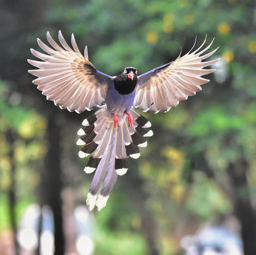

In [ ]:
#|eval: false
functions.download_pic('bird', n_images = 1, show_progress=True, recreate = False)

...and then download a URL and take a look at it:

Now let's do the same with "forest photos":

Image file exists.


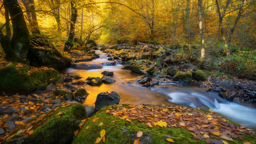

In [ ]:
#|eval: false
functions.download_pic('forest')

In [ ]:
#|code-fold: true
#|eval: false
searches = ('forest','bird')
path = Path('bird_or_not')

functions.create_data_folder(folder_path=path,
                             searches=searches,
                             amount=200,
                            recreate= True)

created forest folder
created bird folder
downloading 200 images for:forest
downloading 200 images for:bird
Number of images failed: 41
resizing images for: forest
resizing images for: bird


## Creating the model

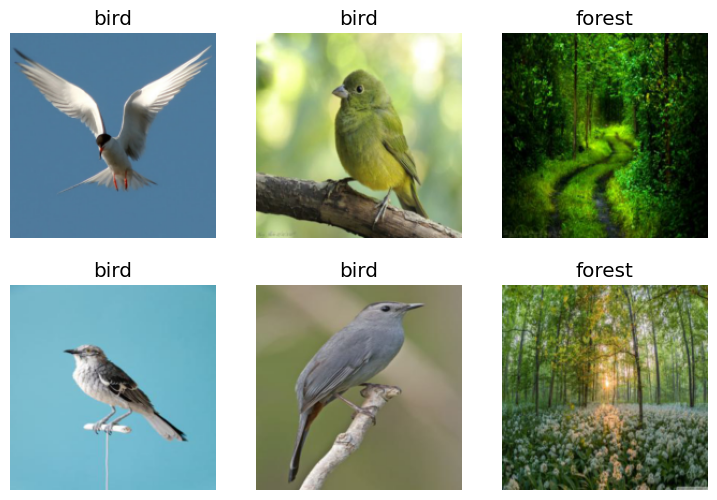

In [ ]:
#|eval: false
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')],
    
)

dls = dls.dataloaders(path, bs = 16)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 
    
To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

## Traning the model
Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.1

In [ ]:
#|eval: false
import timm

In [ ]:
#|eval: false
timm.list_models('resnet1*')[0:5]

['resnet10t', 'resnet14t', 'resnet18', 'resnet18d', 'resnet101']

In [ ]:
#|eval: false
learn = vision_learner(dls, 'resnet18', metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.548197,0.021149,0.000000,00:02


/home/thekkel/mambaforge/envs/cfast/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


epoch,train_loss,valid_loss,error_rate,time
0,0.088692,0.020339,0.000000,00:02
1,0.088422,0.018556,0.014925,00:01
2,0.131681,0.016558,0.000000,00:02
3,0.130796,0.021200,0.014925,00:01
4,0.112642,0.015702,0.000000,00:01


## Step 3: Use our model (and build your own!)
Let's see what our model thinks about that bird we downloaded at the start:

In [ ]:
#|eval: false
is_bird,_,probs = learn.predict(PILImage.create('bird0.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9999


In [ ]:
#|eval: false
functions.classify_images(learn, 'bird0.jpg')

{'bird': 99.99223, 'forest': 0.00777}

## Deep Learning Is Not Just for Image Classification

  - SegmentationDataLoaders - Easier than datablocks 
  
```python
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

```

- Tabular analysis - income prediction

```python
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(3)

dls.show_batch()

```


- Collaboration filtering - ratings/ recommendations

```python
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)
learn.show_results()
```

- Example
```python
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', bs=32)
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)
```

This reduces the batch size to 32 (we will explain this later). If you keep hitting the same error, change 32 to 16

- Example
```python
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy)
learn.fine_tune(4, 1e-2)
```